# Import des libraries

In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as sqlio
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy.stats as SS

# Préprocessing des données

## Ajustement des données

In [2]:
substances = ['2378-TCDD', '12378-PCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

substances_A = [sub + '_A' for sub in substances]
substances_C = [sub + '_C' for sub in substances]

total_homologue = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'OCDD', 
    'Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'OCDF']

total_dioxine = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'Total DIOXINE']
total_furanne = ['Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'Total FURANE']

In [3]:
data = pd.read_csv('DioxIA_20201007.csv', sep=';')

data['Type de point de mesure'].replace({"source":"Source"}, inplace=True)
data = data.replace('-', np.nan)
for col in (substances + total_homologue + ['Total DIOXINE', 'Total FURANE']):
    data[col] = data[col].astype(str)
    data[col] = [float(a.replace(',', '.')
                        .replace('94.759.846', "94759.846")
                        .replace('<', '')
                        .replace('ND', '0')
                        .replace('?', '.')
                        .replace(';', '.')
                        .replace('ç', '9')) for a in data[col].values]

In [4]:
columns_process = ['2378-TCDD', '<', '12378-PCDD', '<.1', '123478-HxCDD',
       '<.2', '123678-HxCDD', '<.3', '123789-HxCDD', '<.4', '1234678-HpCDD',
       '<.5', 'OCDD', '<.6', '2378-TCDF', '<.7', '12378-PeCDF',
       '<.8', '23478-PeCDF', '<.9', '123478-HxCDF', '<.10', '123678-HxCDF',
       '<.11', '234678-HxCDF', '<.12', '123789-HxCDF', '<.13', '1234678-HpCDF',
       '<.14', '1234789-HpCDF', '<.15', 'OCDF', '<.16',
       'Total TCDD', '<.17', 'Total PeCDD', '<.18', 'Total HxCDD', '<.19',
       'Total HpCDD', '<.20', 'Total DIOXINE', '<.21', 'Total TCDF', '<.22',
       'Total PeCDF', '<.23', 'Total HxCDF', '<.24', 'Total HpCDF', '<.25',
       'Total FURANE', '<.26']

for col in columns_process:
    if '<' in col:
        coef = []
        for a in data[col].values:
            if(a == '<' or a == 'ND' or a == 0 or a == '0'):
                coef.append(0)
            else:
                coef.append(1)
        data[old_col] = data[old_col] * coef
    else:
        old_col = col


## Normalisation A

In [5]:
table_final = data.copy()
table_final["total sub 2378"] = 0
for sub in substances:
    table_final["total sub 2378"] += table_final[sub]

In [6]:
table_norme_A = table_final.copy()
for sub in substances:
    table_norme_A[sub + '_A'] = table_norme_A[sub]  / table_final["total sub 2378"]

Index(['Fournisseur', 'Nom du projet', 'Réf. échantillon', 'Réf. Synthese',
       'Coord. Lat. Source', 'Coord. Long. Source',
       'Localisation de la source', 'Coord. Lat. Point', 'Coord. Long. Point',
       'Distance à la source (km)',
       ...
       '2378-TCDF_A', '12378-PeCDF_A', '23478-PeCDF_A', '123478-HxCDF_A',
       '123678-HxCDF_A', '234678-HxCDF_A', '123789-HxCDF_A', '1234678-HpCDF_A',
       '1234789-HpCDF_A', 'OCDF_A'],
      dtype='object', length=105)


## Normalisation C

In [7]:
normalisation_C_disc = True

In [8]:
table_norme_C = table_final.copy()

for col in total_homologue:
    table_final["total homologue"] = 0
    table_final["total homologue"] += table_final[col]
table_norme_C = table_final[table_final["total homologue"] > 0]

print("Nombres d'échantillons restants :", len(table_norme_C), "\nPourcentage restant :", len(table_norme_C)*100/len(table_final))

substance_in = {}
for homologue in total_homologue:
    if(homologue != "OCDD" and homologue != "OCDF"):
        list_sub = []
        text_ref_homologue = homologue.replace("Total ", "")
        table_norme_C[text_ref_homologue] = 0
        for sub in substances:
            if sub.find(text_ref_homologue) != -1:
                list_sub.append(sub)
                table_norme_C[text_ref_homologue] += table_norme_C[sub]
        substance_in[homologue] = list_sub
        text_ref_homologue_2 = text_ref_homologue + "_2"
        table_norme_C[text_ref_homologue_2] = table_norme_C[text_ref_homologue] * 0.9
        table_norme_C = table_norme_C[table_norme_C[text_ref_homologue_2] <= table_norme_C[homologue]]
    else:
        substance_in[homologue] = [homologue]

Nombres d'échantillons restants : 1306 
Pourcentage restant : 87.35785953177258


In [9]:
table_norme_C['TOTAL PCDD'] = table_norme_C['TCDD'] + table_norme_C['PeCDD'] + table_norme_C['HxCDD'] + table_norme_C['HpCDD'] + table_norme_C['OCDD']
table_norme_C['TOTAL PCDF'] = table_norme_C['TCDF'] + table_norme_C['PeCDF'] + table_norme_C['HxCDF'] + table_norme_C['HpCDF'] + table_norme_C['OCDF'] 

for homologue in total_homologue:
    for sub in substance_in[homologue]:
        if sub == 'OCDD':
            if(normalisation_C_disc):
                table_norme_C['OCDD'] = table_norme_C['OCDD'] / table_norme_C['TOTAL PCDD']
            else:
                table_norme_C[sub] = 1
        elif sub == 'OCDF':
            if(normalisation_C_disc):
                table_norme_C['OCDF'] = table_norme_C['OCDF'] / table_norme_C['TOTAL PCDF']
            else:
                table_norme_C[sub] = 1
        else:
            table_norme_C[sub] = table_norme_C[sub] / table_norme_C[homologue]
table_norme_C = table_norme_C.fillna(0)
table_norme_C = table_norme_C.replace(np.inf, 0)
renaming = { pre : nex for (pre, nex) in zip(substances, substances_C) }
table_norme_C = table_norme_C.rename(columns = renaming)
print("Nombres d'échantillons restants :", len(table_norme_C), "\nPourcentage restant :", len(table_norme_C)*100/len(table_final))

Nombres d'échantillons restants : 835 
Pourcentage restant : 55.852842809364546


In [10]:
table_total = table_norme_A[["Nom du projet", "Type de point de mesure", "Matrice", "Contexte", "Source", "Fournisseur"] + substances_A].merge(table_norme_C[substances_C], how='left', left_index=True, right_index=True)
table_total = table_total[table_total["Fournisseur"] != "US EPA"]

# Comparaisons

## Projet SIVERT (par matrice en fonction de la mesure)

### Vision synthétique

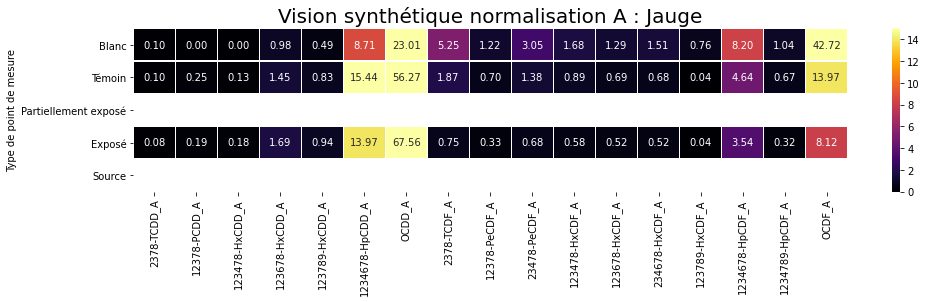

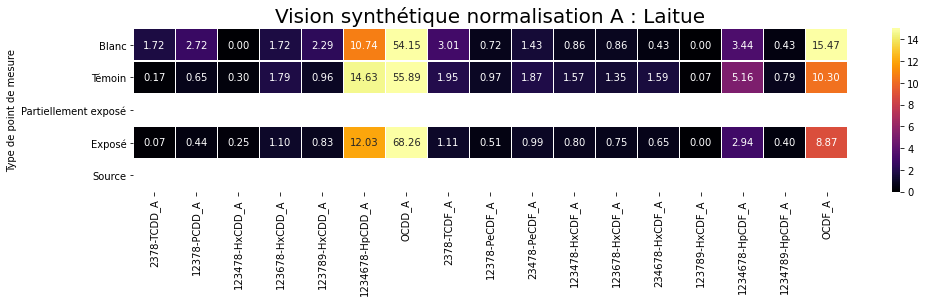

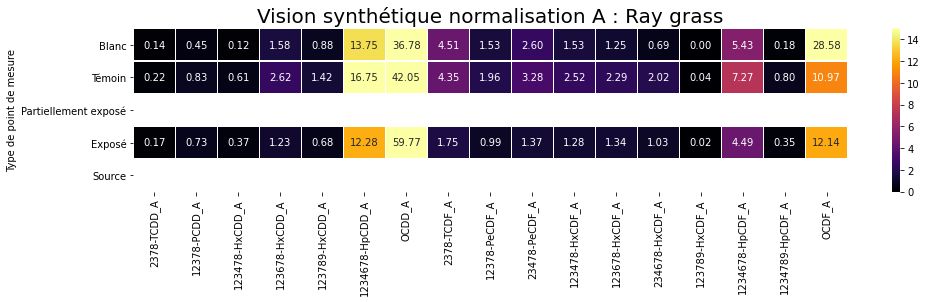

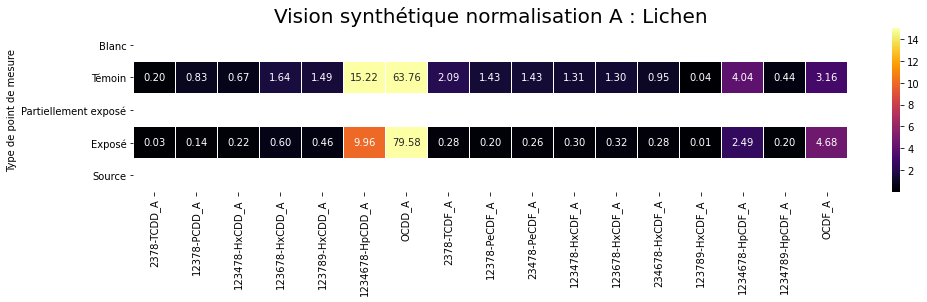

In [11]:
project = 'SIVERT'
varexp = "Type de point de mesure"
matrice_list = ["Jauge", "Laitue", "Ray grass", "Lichen"]

for matrice in matrice_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & (table_total["Matrice"] == matrice)][substances_A + [varexp]].copy()
    df_analyse_final = df_analyse_final.dropna()

    visu = df_analyse_final.groupby([varexp]).mean()

    f, ax = plt.subplots(figsize=(16, 3))
    plt.title(f"Vision synthétique normalisation A : " + matrice,fontsize=20)
    sns.heatmap(visu.reindex(["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source"]) * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

In [12]:
matrice_list = ["Jauge", "Laitue", "Ray grass", "Lichen"]
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source"]
df_matrice = pd.DataFrame(columns=["Matrice", "Mesure 1", "Mesure 2", "Score dot", "Score index", "Score Pearson"])
a = 0

for matrice in matrice_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & (table_total["Matrice"] == matrice)][substances_A + ["Type de point de mesure"]].copy()
    df_analyse_final = df_analyse_final.dropna()

    for (i, mesure1) in enumerate(mesure_list):
        for (j, mesure2) in enumerate(mesure_list):
            if (i != j):
                data1 = df_analyse_final[df_analyse_final["Type de point de mesure"] == mesure1][substances_A].copy()
                data2 = df_analyse_final[df_analyse_final["Type de point de mesure"] == mesure2][substances_A].copy()
                if (len(data1) == 0 or len(data2) == 0):
                    df_matrice.loc[a] = [matrice, mesure1, mesure2, np.nan, np.nan, np.nan]
                else:
                    mean1 = data1.mean()
                    mean2 = data2.mean()

                    df_matrice.loc[a] = [matrice, mesure1, mesure2, np.dot(mean1, mean2), np.dot(np.sqrt(mean1), np.sqrt(mean2)), SS.pearsonr(mean1, mean2)[0]]
            else:
                df_matrice.loc[a] = [matrice, mesure1, mesure2, np.nan, np.nan, np.nan]
            a += 1

In [13]:
matrice_target = "Jauge"

### Score de ressemblance

In [14]:
pd.pivot_table(df_matrice[df_matrice["Matrice"] == matrice_target], values='Score dot', index='Mesure 1', columns='Mesure 2')

Mesure 2,Blanc,Exposé,Témoin
Mesure 1,,,
Blanc,NaN,0.206355,0.208512
Exposé,0.206355,NaN,0.415439
Témoin,0.208512,0.415439,NaN


In [15]:
pd.pivot_table(df_matrice[df_matrice["Matrice"] == matrice_target], values='Score index', index='Mesure 1', columns='Mesure 2')

Mesure 2,Blanc,Exposé,Témoin
Mesure 1,,,
Blanc,NaN,0.840164,0.904079
Exposé,0.840164,NaN,0.989964
Témoin,0.904079,0.989964,NaN


In [16]:
pd.pivot_table(df_matrice[df_matrice["Matrice"] == matrice_target], values='Score Pearson', index='Mesure 1', columns='Mesure 2')

Mesure 2,Blanc,Exposé,Témoin
Mesure 1,,,
Blanc,NaN,0.511128,0.613215
Exposé,0.511128,NaN,0.990818
Témoin,0.613215,0.990818,NaN


## Projet SIVERT (par mesure en fonction de la matrice)

### Vision synthétique

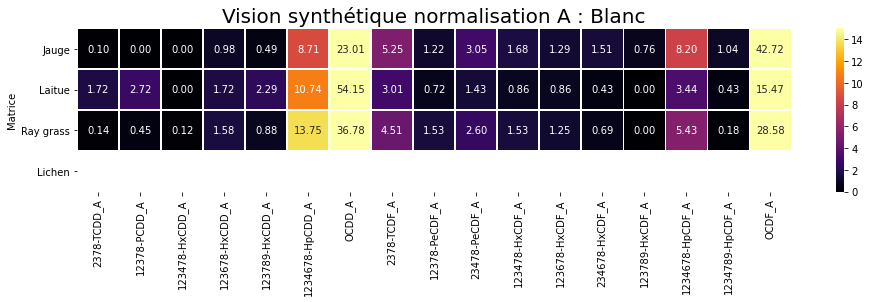

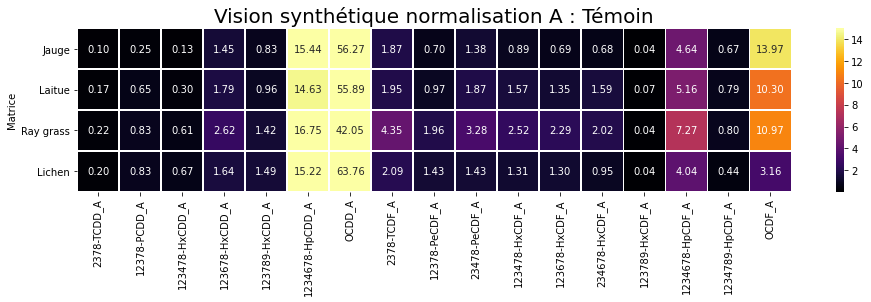

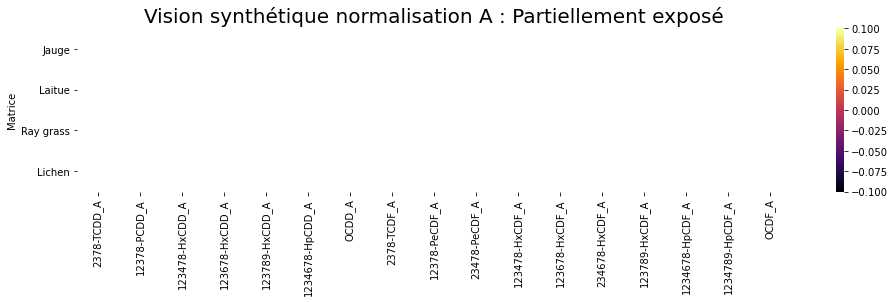

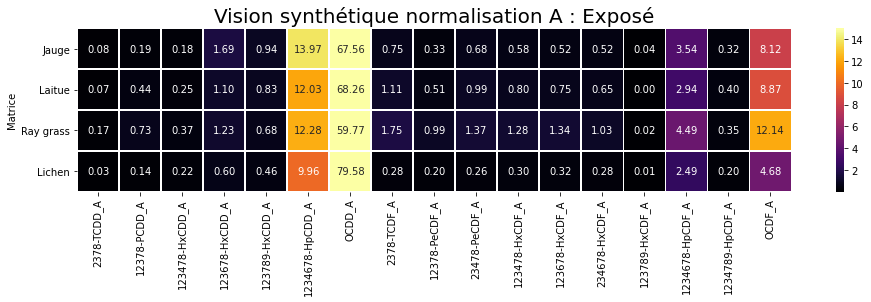

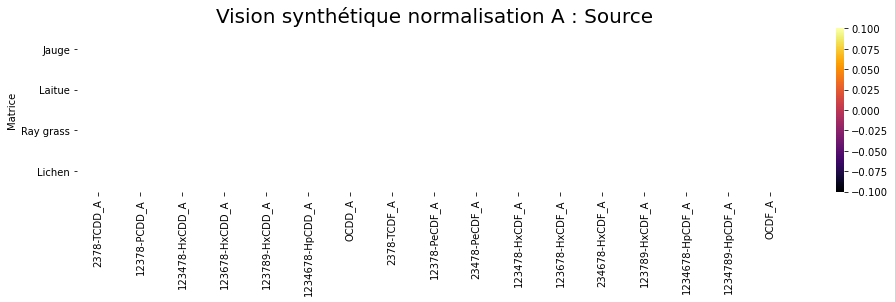

In [17]:
project = 'SIVERT'
varexp = "Matrice"
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source"]

for mesure in mesure_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & (table_total["Type de point de mesure"] == mesure)][substances_A + [varexp]].copy()
    df_analyse_final = df_analyse_final.dropna()

    visu = df_analyse_final.groupby([varexp]).mean()

    f, ax = plt.subplots(figsize=(16, 3))
    plt.title(f"Vision synthétique normalisation A : " + mesure,fontsize=20)
    sns.heatmap(visu.reindex(["Jauge", "Laitue", "Ray grass", "Lichen"]) * 100, annot=True, fmt="04.2f", linewidths=.5, ax=ax, cmap = plt.cm.inferno, vmax = 15)

In [18]:
matrice_list = ["Jauge", "Laitue", "Ray grass", "Lichen"]
mesure_list = ["Blanc", "Témoin", "Partiellement exposé", "Exposé", "Source"]
df_mesure = pd.DataFrame(columns=["Mesure", "Matrice 1", "Matrice 2", "Score dot", "Score index", "Score Pearson"])
a = 0

for mesure in mesure_list:
    df_analyse_final = table_total[(table_total["Nom du projet"] == project) & (table_total["Type de point de mesure"] == mesure)][substances_A + ["Matrice"]].copy()
    df_analyse_final = df_analyse_final.dropna()

    for (i, matrice1) in enumerate(matrice_list):
        for (j, matrice2) in enumerate(matrice_list):
            if (i != j):
                data1 = df_analyse_final[df_analyse_final["Matrice"] == matrice1][substances_A].copy()
                data2 = df_analyse_final[df_analyse_final["Matrice"] == matrice2][substances_A].copy()
                if (len(data1) == 0 or len(data2) == 0):
                    df_mesure.loc[a] = [mesure, matrice1, matrice2, np.nan, np.nan, np.nan]
                else:
                    mean1 = data1.mean()
                    mean2 = data2.mean()

                    df_mesure.loc[a] = [mesure, matrice1, matrice2, np.dot(mean1, mean2), np.dot(np.sqrt(mean1), np.sqrt(mean2)), SS.pearsonr(mean1, mean2)[0]]
            else:
                df_matrice.loc[a] = [matrice, mesure1, mesure2, np.nan, np.nan, np.nan]
            a += 1

### Score de ressemblance

In [19]:
mesure_target = "Exposé"

In [20]:
pd.pivot_table(df_mesure[df_mesure["Mesure"] == mesure_target], values='Score dot', index='Matrice 1', columns='Matrice 2')

Matrice 2,Jauge,Laitue,Lichen,Ray grass
Matrice 1,,,,
Jauge,NaN,0.486817,0.556512,0.433209
Laitue,0.486817,NaN,0.560368,0.435800
Lichen,0.556512,0.560368,NaN,0.495073
Ray grass,0.433209,0.435800,0.495073,NaN


In [21]:
pd.pivot_table(df_mesure[df_mesure["Mesure"] == mesure_target], values='Score index', index='Matrice 1', columns='Matrice 2')

Matrice 2,Jauge,Laitue,Lichen,Ray grass
Matrice 1,,,,
Jauge,NaN,0.997984,0.989334,0.990143
Laitue,0.997984,NaN,0.988262,0.994179
Lichen,0.989334,0.988262,NaN,0.968289
Ray grass,0.990143,0.994179,0.968289,NaN


In [22]:
pd.pivot_table(df_mesure[df_mesure["Mesure"] == mesure_target], values='Score Pearson', index='Matrice 1', columns='Matrice 2')

Matrice 2,Jauge,Laitue,Lichen,Ray grass
Matrice 1,,,,
Jauge,NaN,0.999319,0.995445,0.996537
Laitue,0.999319,NaN,0.996835,0.997109
Lichen,0.995445,0.996835,NaN,0.988452
Ray grass,0.996537,0.997109,0.988452,NaN
